# Xopt CNSGA algorithm

In [1]:
from xopt.generators.ga.cnsga import CNSGAGenerator

from xopt.resources.test_functions.tnk import evaluate_TNK, tnk_vocs

from xopt import Xopt, Evaluator

In [2]:
# Useful for debugging
#%load_ext autoreload
#%autoreload 2

In [3]:
ev = Evaluator(function=evaluate_TNK)
ev.function_kwargs = {'raise_probability':0.1} # optional random crashing, to mimic real-world use. 

In [4]:
X = Xopt(
    generator=CNSGAGenerator(tnk_vocs),
    evaluator=ev,
    vocs=tnk_vocs,
)

In [5]:
%%time
# Run 100 generations
for _ in range(64 * 20):
    X.step()

CPU times: user 5.03 s, sys: 3.92 ms, total: 5.03 s
Wall time: 5.03 s


# Plot 

In [6]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [7]:
def plot_population(X):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    fdata = tnk_vocs.feasibility_data(X.data)
    
    k1 = "x1"
    k2 = "x2"
    
    X.data.plot.scatter(k1, k2, marker=".", alpha=0.1, color="black", ax=ax)
    X.data[fdata["feasible"]].plot.scatter(
        k1, k2, marker="x", alpha=0.3, color="orange", ax=ax
    )
    X.generator.population.plot.scatter(k1, k2, marker="o", color="red", alpha=1, ax=ax)
    ax.set_xlabel(k1)
    ax.set_ylabel(k2)
    ax.set_xlim(0, 1.5)
    ax.set_ylim(0, 1.5)
    ax.set_title("TNK with Xopt's CNSGA")

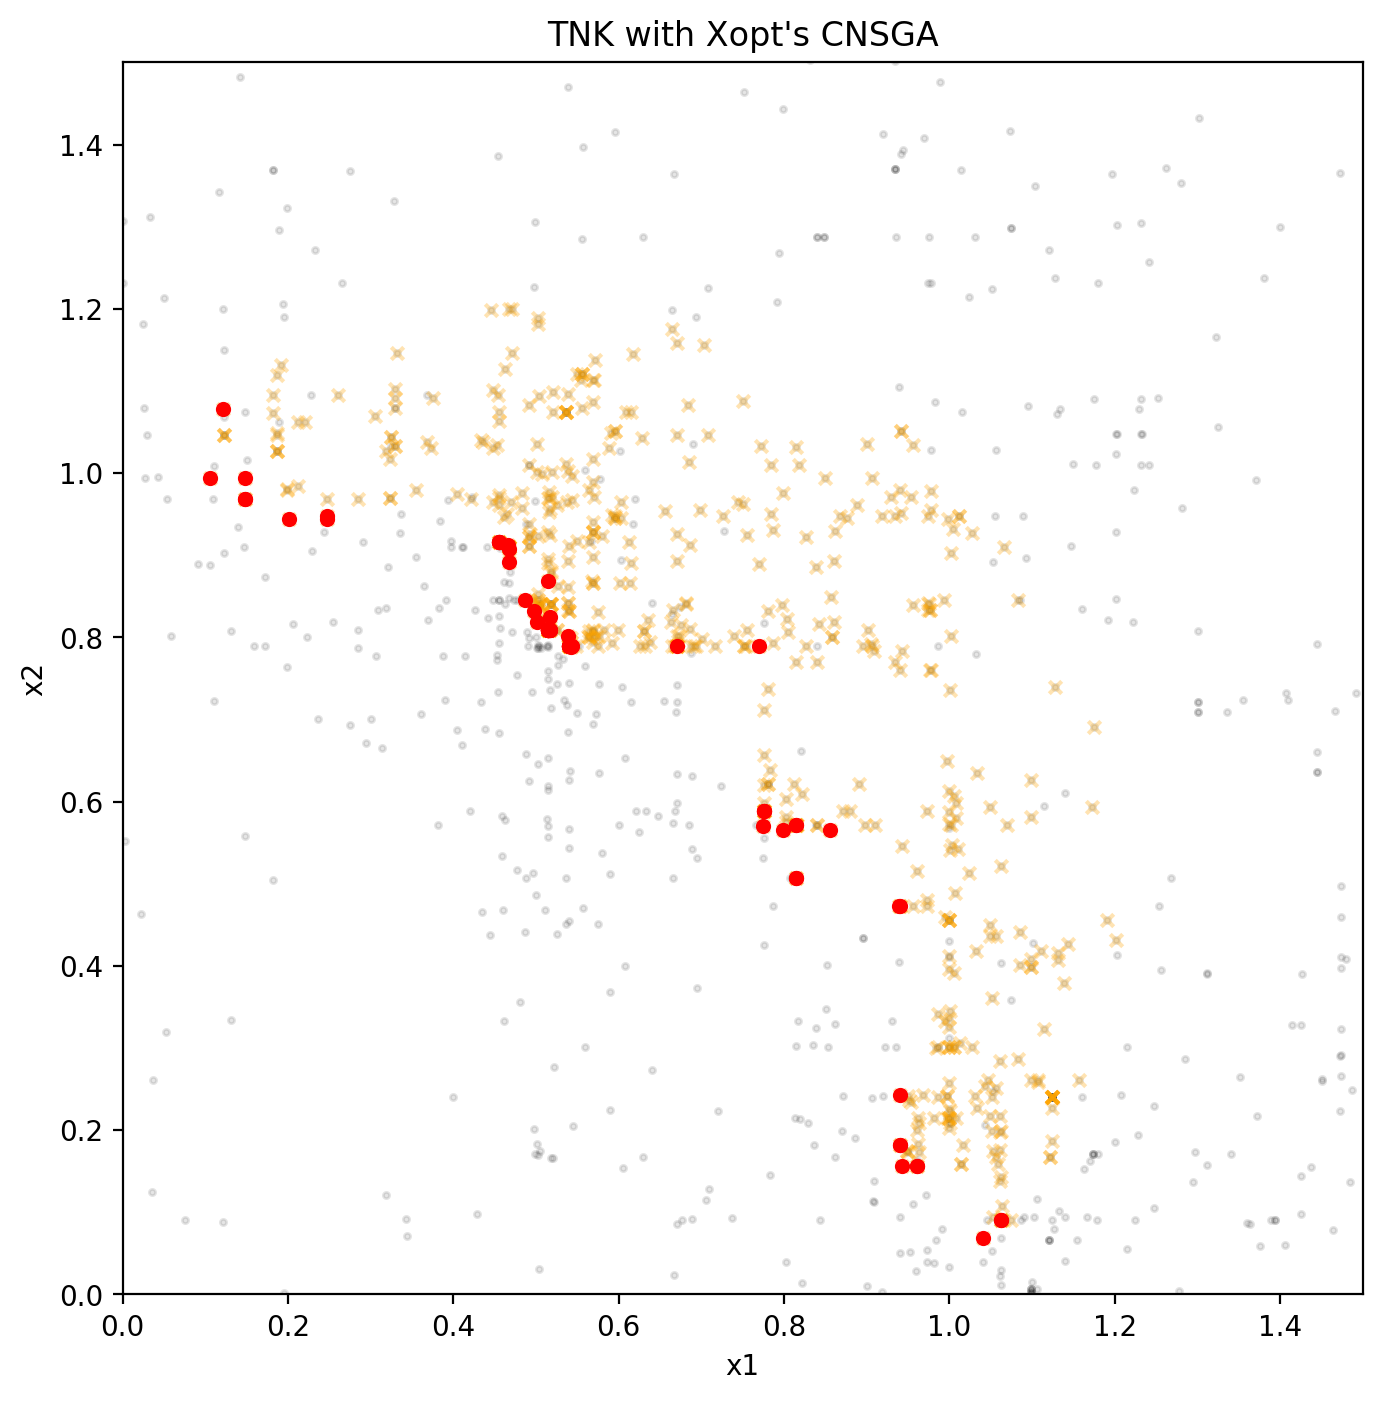

In [8]:
plot_population(X)

In [9]:
# Write the current population
X.generator.write_population('test.csv')

# YAML method

In [10]:
from xopt import Xopt

In [11]:
YAML = """
xopt:
    max_evaluations: 6400
generator:
    name: cnsga
    population_size: 64
    population_file: test.csv
    output_path: .

evaluator:
    function: xopt.resources.test_functions.tnk.evaluate_TNK
    function_kwargs:
      raise_probability: 0.1

vocs:
    variables:
        x1: [0, 3.14159]
        x2: [0, 3.14159]
    objectives: {y1: MINIMIZE, y2: MINIMIZE}
    constraints:
        c1: [GREATER_THAN, 0]
        c2: [LESS_THAN, 0.5]
    linked_variables: {x9: x1}
    constants: {a: dummy_constant}

"""

X = Xopt(YAML)
X


            Xopt
________________________________
Version: 0+untagged.1.g504ad2a
Data size: 0
Config as YAML:
xopt: {asynch: false, strict: false, dump_file: null, max_evaluations: 6400}
generator: {name: cnsga, population_size: 64, crossover_probability: 0.9, mutation_probability: 1.0,
  population_file: test.csv, output_path: .}
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  max_workers: 1
  function_kwargs: {sleep: 0, random_sleep: 0, raise_probability: 0.1}
  vectorized: false
vocs:
  variables:
    x1: [0.0, 3.14159]
    x2: [0.0, 3.14159]
  constraints:
    c1: [GREATER_THAN, 0.0]
    c2: [LESS_THAN, 0.5]
  objectives: {y1: MINIMIZE, y2: MINIMIZE}
  constants: {a: dummy_constant}
  linked_variables: {x9: x1}


In [12]:
# This will have loaded children from the population file. These will need to be re-evaluated.
len(X.generator.children)

64

In [13]:
%%time
X.run()

CPU times: user 25.8 s, sys: 83.9 ms, total: 25.8 s
Wall time: 25.8 s


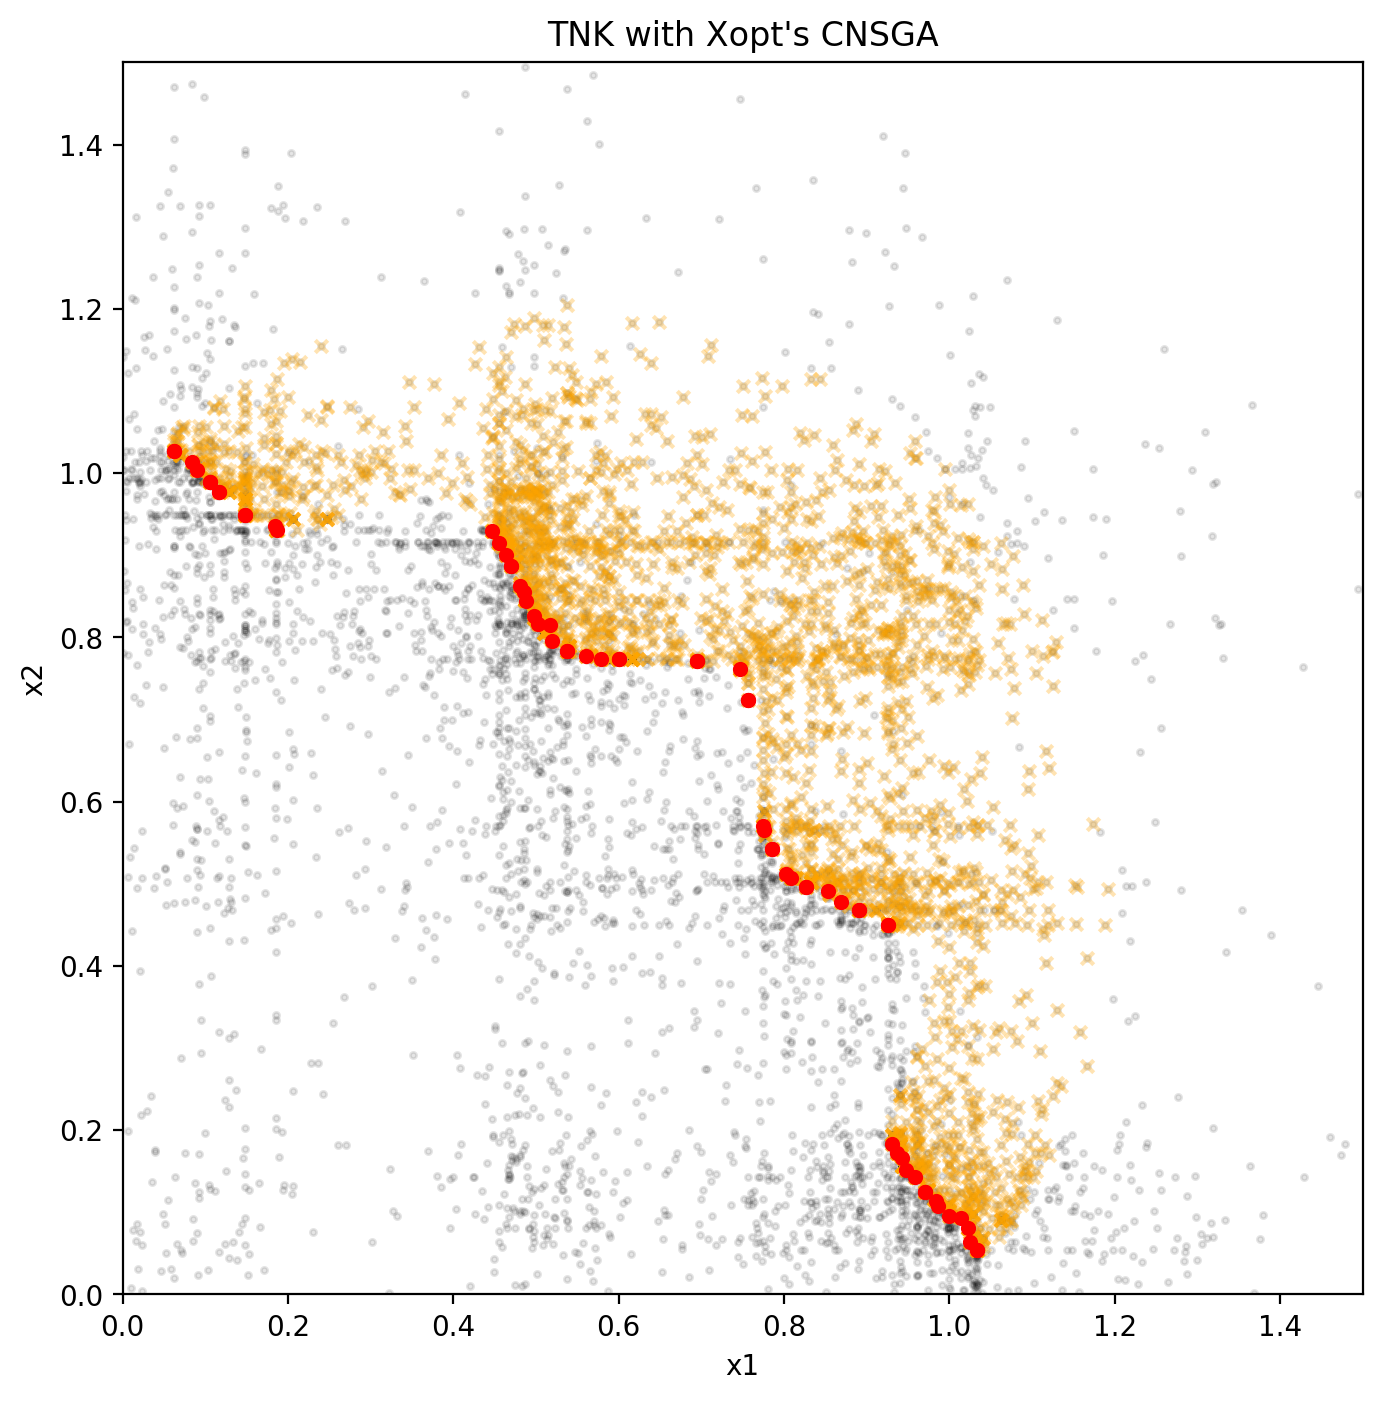

In [14]:
plot_population(X)

In [15]:
len(X.data)

6400

In [16]:
# With output_path set, these are written
from glob import glob
pop_files = sorted(glob("cnsga_population*"))
pop_files

['cnsga_population_2022-08-31T15:06:11.594863+00:00.csv',
 'cnsga_population_2022-08-31T15:06:11.841728+00:00.csv',
 'cnsga_population_2022-08-31T15:06:12.095835+00:00.csv',
 'cnsga_population_2022-08-31T15:06:12.345355+00:00.csv',
 'cnsga_population_2022-08-31T15:06:12.595671+00:00.csv',
 'cnsga_population_2022-08-31T15:06:12.846903+00:00.csv',
 'cnsga_population_2022-08-31T15:06:13.097824+00:00.csv',
 'cnsga_population_2022-08-31T15:06:13.346605+00:00.csv',
 'cnsga_population_2022-08-31T15:06:13.594022+00:00.csv',
 'cnsga_population_2022-08-31T15:06:13.844457+00:00.csv',
 'cnsga_population_2022-08-31T15:06:14.091010+00:00.csv',
 'cnsga_population_2022-08-31T15:06:14.338357+00:00.csv',
 'cnsga_population_2022-08-31T15:06:14.585594+00:00.csv',
 'cnsga_population_2022-08-31T15:06:14.834267+00:00.csv',
 'cnsga_population_2022-08-31T15:06:15.082970+00:00.csv',
 'cnsga_population_2022-08-31T15:06:15.332286+00:00.csv',
 'cnsga_population_2022-08-31T15:06:15.580220+00:00.csv',
 'cnsga_popula

<AxesSubplot:xlabel='x1', ylabel='x2'>

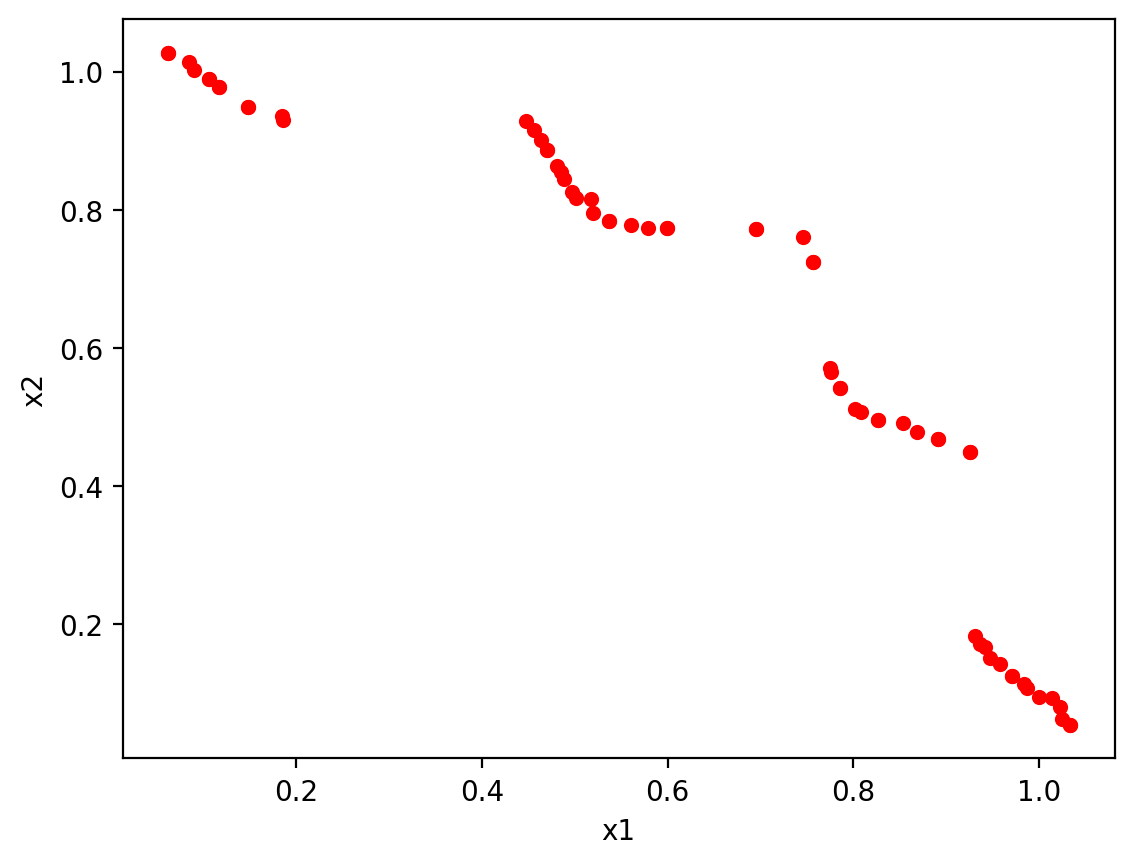

In [17]:
import pandas as pd
pop_df = pd.read_csv(pop_files[-1], index_col="xopt_index")

pop_df.plot.scatter("x1", "x2", marker="o", color="red", alpha=1)

In [18]:
# Cleanup
!rm cnsga_population*
!rm test.csv

# Examine generator

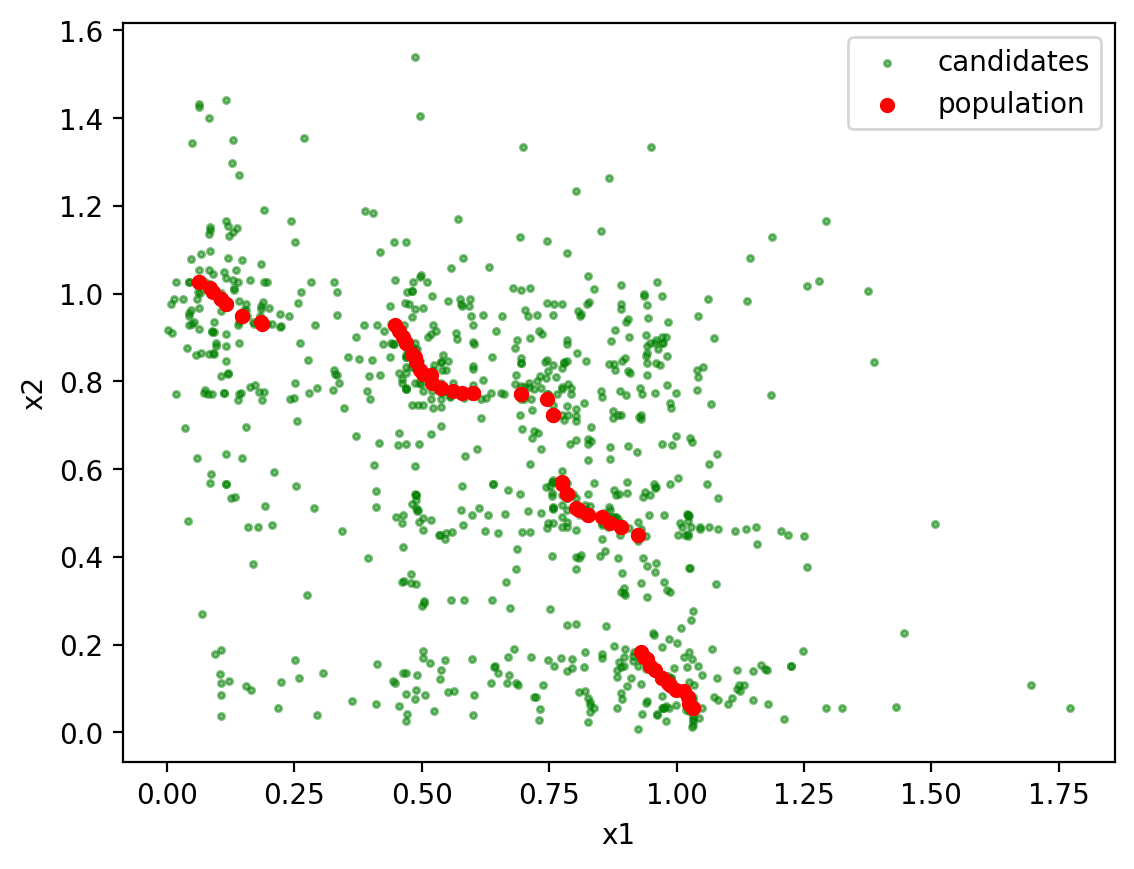

In [19]:
df = pd.DataFrame(X.generator.generate(1000))

fig, ax = plt.subplots()
df.plot.scatter("x1", "x2", marker=".", color="green", alpha=0.5, ax=ax, label='candidates')
pop_df.plot.scatter("x1", "x2", marker="o", color="red", alpha=1, ax=ax, label='population')
plt.legend()

# Vectorized evaluation

Some functions also allow vectorized inputs. This can often be very fast.

However, vectorized evaluation has some restrictions. For example, the output dict cannot append additional arrays with odd lengths.

In [20]:
# Notice that this returns `some_array`
evaluate_TNK({'x1':1, 'x2':1})

{'y1': 1, 'y2': 1, 'c1': 0.9, 'c2': 0.5, 'some_array': array([1, 2, 3])}

In [21]:
# Here we make a version that does not have this
def evaluate_TNK2(*args, **kwargs):
    outputs = evaluate_TNK(*args, **kwargs)
    outputs.pop('some_array')
    return outputs

In [22]:
from xopt import Xopt

YAML = """
xopt:
    max_evaluations: 6400
generator:
    name: cnsga
    population_size: 64

evaluator:
    function: __main__.evaluate_TNK2
    function_kwargs:
      raise_probability: 0.1
    vectorized: True
    max_workers: 100 

vocs:
    variables:
        x1: [0, 3.14159]
        x2: [0, 3.14159]
    objectives: {y1: MINIMIZE, y2: MINIMIZE}
    constraints:
        c1: [GREATER_THAN, 0]
        c2: [LESS_THAN, 0.5]
    linked_variables: {x9: x1}
    constants: {a: dummy_constant}

"""


X2 = Xopt(YAML)
X2.evaluator.function = evaluate_TNK2

X2.run()

len(X2.data)

6400

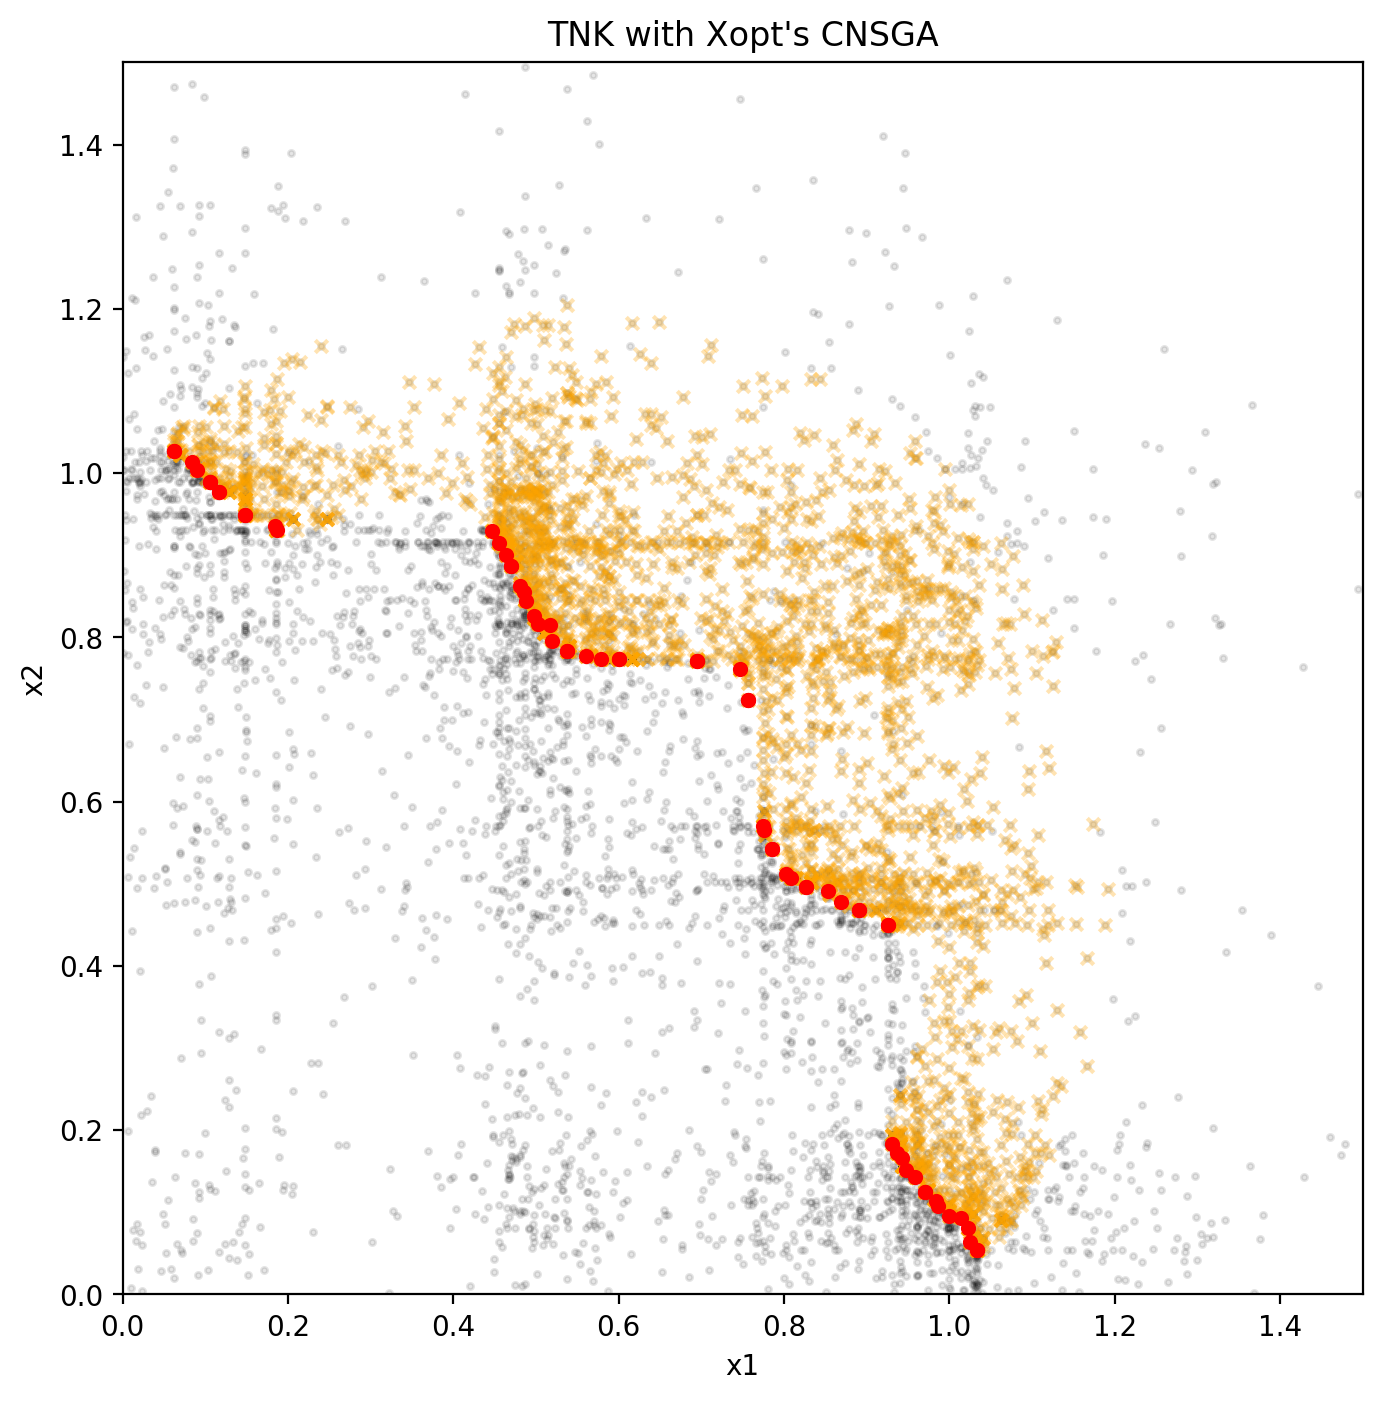

In [23]:
plot_population(X)